# Woods

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator 

from lcs.agents import EnvironmentAdapter
from lcs import Perception

import gym
import gym_woods

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

In [48]:
# Import utils functions
%run utils/experiments.py
%run utils/metrics.py
%run utils/plots.py
%run utils/payoff_landscape.py
%run utils/basic_rl.py

## Environment setup

In [35]:
env = gym.make('Woods1-v0')

In [36]:
class WoodsAdapter(EnvironmentAdapter):
    @classmethod
    def to_genotype(cls, phenotype):
        result = []
        for el in phenotype:
            if el == 'F':
                result.extend(['1', '1', '0'])
            if el == 'G':
                result.extend(['1', '1', '1'])
            if el == 'O':
                result.extend(['0', '1', '0'])
            if el == 'Q':
                result.extend(['0', '1', '1'])
            if el == '.':
                result.extend(['0', '0', '0'])

        return result

## Basic Metrics
Examine population size, rho parameter and exploitation capabilities.

In [37]:
# Params
learning_rate = 0.8
discount_factor = 0.95
epsilon = 0.1
zeta = 0.0001

# Set ACS2/AACS2 configuration parameter dictionary
basic_cfg = {
    'perception_bits': 8,
    'possible_actions': 8,
    'do_ga': True,
    'beta': learning_rate,
    'epsilon': 1-epsilon,
    'gamma': discount_factor,
    'zeta': zeta,
    'environment_adapter': EnvironmentAdapter,  # basic adapter
    'user_metrics_collector_fcn': common_metrics,
    'biased_exploration_prob': 0,
    'metrics_trial_freq': 1
}

In [24]:
%%time

# min 10_000 trials
agg_df = avg_experiments(10, trials=1_000, env=env, params=basic_cfg)

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9
CPU times: user 57min 52s, sys: 12.3 s, total: 58min 5s
Wall time: 59min 16s


In [18]:
agg_df

phase  steps_in_trial       rho  population  reliable
agent    trial                                                         
AACS2_v1 0      explore               9  0.100000           7         0
         1      exploit               3  0.199970           7         0
         2      explore              16  0.199970          16         1
         3      exploit              50  0.198973          16         1
         4      explore               5  0.198953          19         1
...                 ...             ...       ...         ...       ...
ACS2     4995   exploit               4  0.000000         184       172
         4996   explore              27  0.000000         183       171
         4997   exploit               1  0.000000         183       171
         4998   explore              12  0.000000         187       171
         4999   exploit               3  0.000000         187       171

[15000 rows x 5 columns]

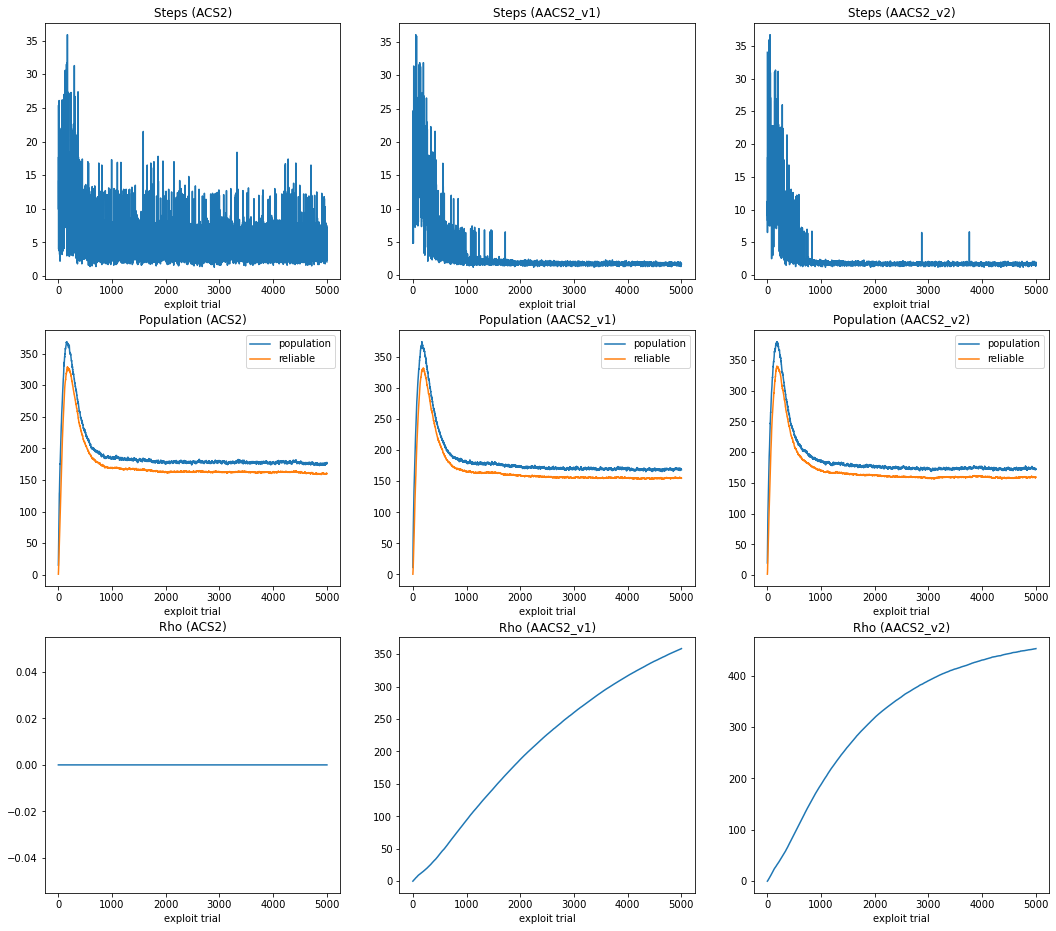

In [25]:
plot_exploit_results(agg_df)

## Payoff Landscape

In [38]:
state_actions = env.env._state_action()
state_actions

{('0', '0'): [0, 1, 2, 4, 5, 6, 7],
 ('1', '0'): [0, 1, 2, 5, 6, 7],
 ('2', '0'): [0, 1, 2, 3, 6, 7],
 ('3', '0'): [0, 1, 2, 3, 4, 6, 7],
 ('4', '0'): [0, 1, 2, 3, 4, 5, 6, 7],
 ('0', '1'): [0, 1, 4, 5, 6, 7],
 ('4', '1'): [0, 1, 2, 3, 4, 6, 7],
 ('0', '2'): [0, 4, 5, 6, 7],
 ('4', '2'): [0, 1, 2, 3, 4, 7],
 ('0', '3'): [0, 3, 4, 5, 6, 7],
 ('4', '3'): [0, 1, 2, 3, 4, 5],
 ('0', '4'): [0, 2, 3, 4, 5, 6, 7],
 ('1', '4'): [2, 3, 4, 5, 6, 7],
 ('2', '4'): [2, 3, 4, 5, 6],
 ('3', '4'): [1, 2, 3, 4, 5, 6],
 ('4', '4'): [0, 1, 2, 3, 4, 5, 6]}

In [55]:
# Assign each state an unique ID and get agent perception of it
sp = {idx: dict(
    perception=env.env._perception(int(i[0][0]), int(i[0][1])),
    actions=i[1],
) for idx, i in enumerate(state_actions.items())}

sp

{0: {'perception': ['.', '.', '.', 'O', '.', '.', '.', '.'],
  'actions': [0, 1, 2, 4, 5, 6, 7]},
 1: {'perception': ['.', '.', '.', 'O', 'O', '.', '.', '.'],
  'actions': [0, 1, 2, 5, 6, 7]},
 2: {'perception': ['.', '.', '.', 'F', 'O', 'O', '.', '.'],
  'actions': [0, 1, 2, 3, 6, 7]},
 3: {'perception': ['.', '.', '.', '.', 'F', 'O', '.', '.'],
  'actions': [0, 1, 2, 3, 4, 6, 7]},
 4: {'perception': ['.', '.', '.', '.', '.', 'F', '.', '.'],
  'actions': [0, 1, 2, 3, 4, 5, 6, 7]},
 5: {'perception': ['.', '.', 'O', 'O', '.', '.', '.', '.'],
  'actions': [0, 1, 4, 5, 6, 7]},
 6: {'perception': ['.', '.', '.', '.', '.', 'O', 'F', '.'],
  'actions': [0, 1, 2, 3, 4, 6, 7]},
 7: {'perception': ['.', 'O', 'O', 'O', '.', '.', '.', '.'],
  'actions': [0, 4, 5, 6, 7]},
 8: {'perception': ['.', '.', '.', '.', '.', 'O', 'O', 'F'],
  'actions': [0, 1, 2, 3, 4, 7]},
 9: {'perception': ['.', 'O', 'O', '.', '.', '.', '.', '.'],
  'actions': [0, 3, 4, 5, 6, 7]},
 10: {'perception': ['.', '.', '.', '.

In [58]:
# Helper function for getting state ID based on agent perception
def get_state_id(p):
    for idx, data in sp.items():
        if data['perception'] == p:
            return idx
    
    return None

### Data preparation

In [104]:
%%time

pop_acs2, pop_aacs2v1, pop_aacs2v2, _ = run_experiments(env, 500_000, basic_cfg)

CPU times: user 3h 4min 32s, sys: 16.8 s, total: 3h 4min 49s
Wall time: 3h 5min 8s


#### Q-learning

In [105]:
%%time

init_Q = np.zeros((len(sp), env.action_space.n))  # initial Q-table
Q = qlearning(env, 50_000, init_Q, epsilon, learning_rate, discount_factor, perception_to_state_mapper=get_state_id)

CPU times: user 5.4 s, sys: 187 ms, total: 5.59 s
Wall time: 5.45 s


#### R-learning

In [106]:
%%time

init_R = np.zeros((len(sp), env.action_space.n))  # initial R-table
R, rho = rlearning(env, 50_000, init_R, epsilon, learning_rate, zeta, perception_to_state_mapper=get_state_id)

CPU times: user 6.2 s, sys: 108 ms, total: 6.31 s
Wall time: 6.24 s


In [107]:
rho

713.1891342595947

### Landscape plot

In [108]:
payoffs = {}

for idx, data in sp.items():
    p = Perception((data['perception']))
    
    for action in data['actions']:
        
        # ACS2
        acs2_match_set = pop_acs2.form_match_set(p)
        acs2_action_set = acs2_match_set.form_action_set(action)

        # AACS2_v1
        aacs2v1_match_set = pop_aacs2v1.form_match_set(p)
        aacs2v1_action_set = aacs2v1_match_set.form_action_set(action)

        # AACS2_v2
        aacs2v2_match_set = pop_aacs2v2.form_match_set(p)
        aacs2v2_action_set = aacs2v2_match_set.form_action_set(action)

        # Check if all states are covered
        for alg, action_set in zip(['ACS2', 'AACS2_v1', 'AACS2_v2'],
                                   [acs2_action_set, aacs2v1_action_set,
                                    aacs2v2_action_set]):
            if len(action_set) == 0:
                print(f"WARN: No {alg} classifiers for perception: {p}, action: {action}")

        payoffs[idx] = {
            'acs2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
            'aacs2-v1': np.mean(list(map(lambda cl: cl.r, aacs2v1_action_set))),
            'aacs2-v2': np.mean(list(map(lambda cl: cl.r, aacs2v2_action_set))),
            'q-learning': Q[idx, action],
            'r-learning': R[idx, action]
        }

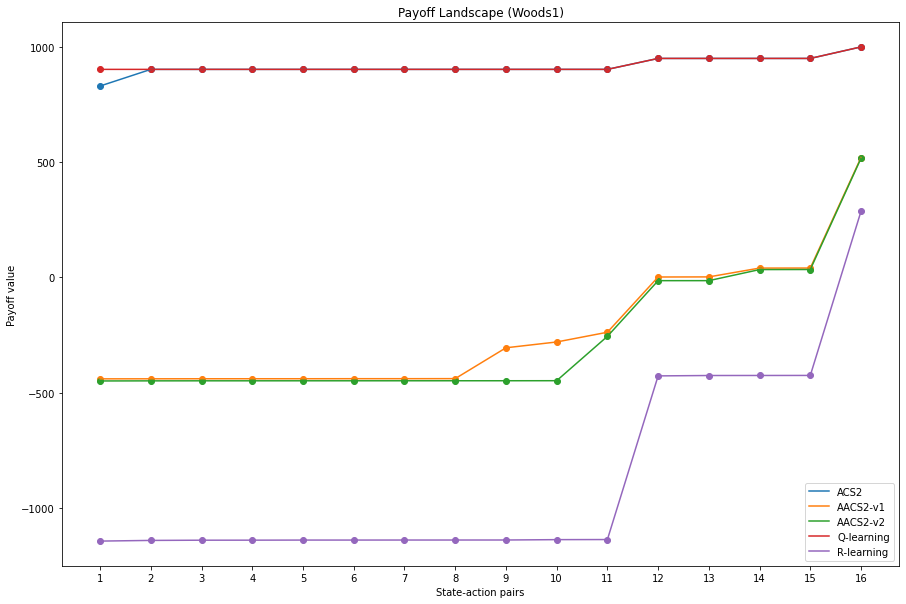

In [109]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)
y_acs2 = sorted([v['acs2'] for k, v in payoffs.items()])
y_aacs2v1 = sorted([v['aacs2-v1'] for k, v in payoffs.items()])
y_aacs2v2 = sorted([v['aacs2-v2'] for k, v in payoffs.items()])
y_qlearning = sorted([v['q-learning'] for k, v in payoffs.items()])
y_rlearning = sorted([v['r-learning'] for k, v in payoffs.items()])

# ACS2
plt.scatter(x, y_acs2)
plt.plot(x, y_acs2, label='ACS2')

# AACS2-v1
plt.scatter(x, y_aacs2v1)
plt.plot(x, y_aacs2v1, label='AACS2-v1')

# AACS2-v2
plt.scatter(x, y_aacs2v2)
plt.plot(x, y_aacs2v2, label='AACS2-v2')

# Q-learning
plt.scatter(x, y_qlearning)
plt.plot(x, y_qlearning, label='Q-learning')

# R-learning
plt.scatter(x, y_rlearning)
plt.plot(x, y_rlearning, label='R-learning')

ax.xaxis.set_major_locator(MultipleLocator(1)) 
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 

ax.set_xlabel("State-action pairs")
ax.set_ylabel("Payoff value")
ax.set_title(f"Payoff Landscape ({env.env.__class__.__name__})")

ax.legend(loc='lower right')

plt.show()